In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
import random
import pandas as pd
pd.set_option('display.max_columns', None)

import torch
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

import neptune
from neptune_pytorch import NeptuneLogger
from neptune.utils import stringify_unsupported

import datetime
import pytz
timeZone = pytz.timezone('America/Los_Angeles')
from operator import itemgetter

from eegUtils import *
from torchModels import * 

# Read the data from Google Drive

In [2]:
dataMultiply = 10**5
sFreq = 256
arrayInCompressedFile = 'arr_7'

data = np.load('/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/elimPeaksSVD001.npz')[arrayInCompressedFile]
nChannel, nSample = data.shape
data = (data * dataMultiply).astype('float32')
dataTensor = torch.tensor(data)
if torch.cuda.is_available():
  dataTensor = dataTensor.to('cuda')
  print("Data has been moved to GPU")
else:
  print("Data is on CPU")
print(data.shape)

Data has been moved to GPU
(19, 1100367)


# Define Model, Optimizer, DataSet and Optionally Load from Drive

In [3]:
# Set parameters
modelType = 'fullyConnected'
loadBool = 0
#modelPath = '/content/drive/MyDrive/NeuroResearch/Data/eegCompress/models/savedModel_03-28 19:04_-0.034.pt'

numSampleInput = 20
numSampleOutput = 1

if modelType == 'fullyConnected':
    inSize = nChannel * numSampleInput
    outSize = nChannel * numSampleOutput
    hiddenLayerSizeList = [300, 300, 300, 300, 300]
    layerSizeList = [inSize] + hiddenLayerSizeList + [outSize]
    model = fullyConnected(nChannel, numSampleInput, layerSizeList)
    dataset = datasetFullyConnected(dataTensor, numSampleInput)
    sizeOfModel = modelSize(model)
elif modelType == 'conv1d':
    model = conv1d(nChannel, numSampleInput)
    dataset = datasetConv1d(dataTensor, numSampleInput)
    sizeOfModel = modelSize(model)
elif modelType == 'fourier':
    model = fourierModel(numSampleInput)
    dataset = datasetFourier(dataTensor, numSampleInput)
    sizeOfModel = modelSize(model)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)
#optimizer = torch.optim.Adam(model.parameters())#, lr = 1e-1, weight_decay = 1e-8)

if loadBool:
  model, optimizer, totalEpoch, loss = loadModel(modelPath, model, optimizer, trainBool=True)
  print("Model has been loaded: " + modelPath)
else:
  totalEpoch = 0

print(model)

if torch.cuda.is_available():
  model.to('cuda')
  print("Model has been moved to GPU")
else:
  print("Model is on CPU")


model size: 1.836MB
fullyConnected(
  (myNet): Sequential(
    (0): Linear(in_features=380, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=300, out_features=300, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=300, out_features=300, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=300, out_features=300, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=300, out_features=19, bias=True)
  )
)
Model has been moved to GPU


In [6]:
logFlag = True

if logFlag:
  run = neptune.init_run(
      project="jettinger35/eegCompress",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIzMjFlMzY2MS1iOWZiLTRmZWEtOGMwNy0zOTVkMTljOGVjYTMifQ==",
      #with_id="EEG-116"
      )

  npt_logger = NeptuneLogger(
      run=run,
      model=model)

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jettinger35/eegCompress/e/EEG-224


# Training loop

In [ ]:
epochs = 50
batchSize = 32
numRandomPlot = 2
secondsToPlot = 5
saveEveryNEpochs = 5 # 0 for no saving

# initialize
breakFlag = False
loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False, sampler=None)

# training loop
for epoch in range(epochs):
    counter = 0

    print("Epoch: " + str(totalEpoch))
    if breakFlag:
      print("Break!")
      break
    for (thisBlock, label) in loader:
        counter += 1
        prediction = model(thisBlock)
        if np.any(np.isnan(prediction.detach().cpu().numpy())):
            print("NaN detected.  Counter: " + str(counter))
            breakFlag = True
            break
        loss = loss_function(prediction, label)

        optimizer.zero_grad()
        loss.backward()

        max_norm = 1.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        optimizer.step()
        if logFlag:
            run[npt_logger.base_namespace]["train/log_loss"].append(np.log(loss.item()))

    if logFlag:
      # plot random locations for original and predicted for comparison
      for i in range(numRandomPlot):

          startPlot = random.randint(0, nSample - (secondsToPlot * sFreq))
          fig, original, predicted = timeSeriesCompare(model, startPlot, secondsToPlot, sFreq, data, numSampleInput)
          plt.title("Epoch, Start, Blocks: " + str((totalEpoch, startPlot, secondsToPlot)))
          run["fig"].append(fig)
          plt.close()

    totalEpoch += 1

    print("Predicting and generating sampler...")
    sampler, predicted, residualMeasure = samplerMake(model, numSampleInput, data)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False, sampler=sampler)

    if saveEveryNEpochs > 0 and (epoch + 1) % saveEveryNEpochs == 0:
      saveModel(model, optimizer, totalEpoch, loss, predicted)

print("Finished training...")

Epoch: 50
Predicting and generating sampler...
Residual measure: 1.5350472582013983
Epoch: 51
Predicting and generating sampler...
Residual measure: 1.3643422471849542
Epoch: 52
Predicting and generating sampler...
Residual measure: 1.4009140416195518
Epoch: 53
Predicting and generating sampler...
Residual measure: 1.342402197812733
Epoch: 54
Predicting and generating sampler...
Residual measure: 1.3640127966278477
Model has been saved: savedModel_03-28 15:36_-0.024.pt
Epoch: 55
Predicting and generating sampler...
Residual measure: 1.374902772276025
Epoch: 56
Predicting and generating sampler...
Residual measure: 1.3642288728764183
Epoch: 57
Predicting and generating sampler...
Residual measure: 1.3741223467023749
Epoch: 58
Predicting and generating sampler...
Residual measure: 1.383317072140543
Epoch: 59
Predicting and generating sampler...
Residual measure: 1.3142531074975665
Model has been saved: savedModel_03-28 15:59_-0.034.pt
Epoch: 60
Predicting and generating sampler...
Residu

# Save the model

In [ ]:
sampler, predicted, residualMeasure = samplerMake(model, numSampleInput, data)
saveModel(model, optimizer, totalEpoch, loss, predicted)

Model has been saved: savedModel_03-22 09:01 [1000, 1000, 1000].pt


# Compare the time series

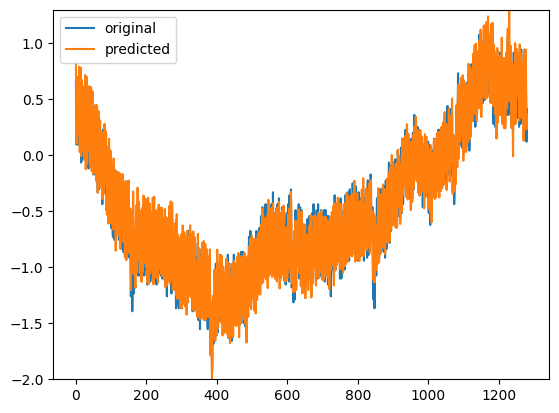

In [ ]:
plotBool = 1

if plotBool:
  startPlot = 1000
  secondsToPlot = 5
  channel = 0
  plotOption = 'both'

  fig, original, predicted64 = timeSeriesCompare(model, startPlot, secondsToPlot, sFreq, data, numSampleInput, channel, plotOption)
  plt.show(fig)

# Save original and predicted data for local graphical comparison

In [ ]:
predicted = predictEEG(model, None, data)

In [ ]:
path = '/content/drive/MyDrive/NeuroResearch/Data/eegCompress/processedData/origAndPredictedSVD001_block7.npz'
dataToSaveList = [data, predicted]
np.savez_compressed(path, *dataToSaveList)

# Show network parameters

In [ ]:
for name, param in model.named_parameters():
    print((name, param.shape))

('myNet.0.weight', torch.Size([50, 19, 3]))
('myNet.0.bias', torch.Size([50]))
('myNet.2.weight', torch.Size([50, 50, 3]))
('myNet.2.bias', torch.Size([50]))
('myNet.4.weight', torch.Size([50, 50, 3]))
('myNet.4.bias', torch.Size([50]))
('myNet.7.weight', torch.Size([19, 700]))
('myNet.7.bias', torch.Size([19]))


# Scratch

In [ ]:
# EXPORT ONNX FOR VISUALIZATION IN NETRON APP

visualizationPath = '/content/drive/MyDrive/NeuroResearch/Data/eegCompress/models/model.onnx'
dataset = datasetMake(torch.tensor(data[:,100:200]), model.numSampleInput, model.typeCode)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None)
batch, label = next(loader.__iter__())
yhat = model(batch)

torch.onnx.export(model, batch, f=visualizationPath)